# Hello RNN timeseries forcasting

In [1]:
# Prerequisites
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("Python Version: ", sys.version)
print("Numpy Version: ", np.__version__)
print("Pandas Version: ", pd.__version__)
print("Tensorflow Version: ", tf.__version__)

Python Version:  3.12.7 (tags/v3.12.7:0b05ead, Oct  1 2024, 03:06:41) [MSC v.1941 64 bit (AMD64)]
Numpy Version:  2.0.2
Pandas Version:  2.2.3
Tensorflow Version:  2.18.0


### Load Data

Chicago Transit Authority ridership data 2001 - 2021

In [2]:
df = pd.read_csv("data/CTA_Ridership_Daily_Boarding_Totals.csv", parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")
# Drop total column
df = df.drop("total", axis=1)
# Remove duplicates
df = df.drop_duplicates()
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


In [3]:
df.tail()

,day_type,bus,rail
date,,,
2021-11-26,W,257700,189694
2021-11-27,A,237839,187065
2021-11-28,U,184817,147830
2021-11-29,W,421322,276090
2021-11-30,W,450230,302349


### Data Exploration

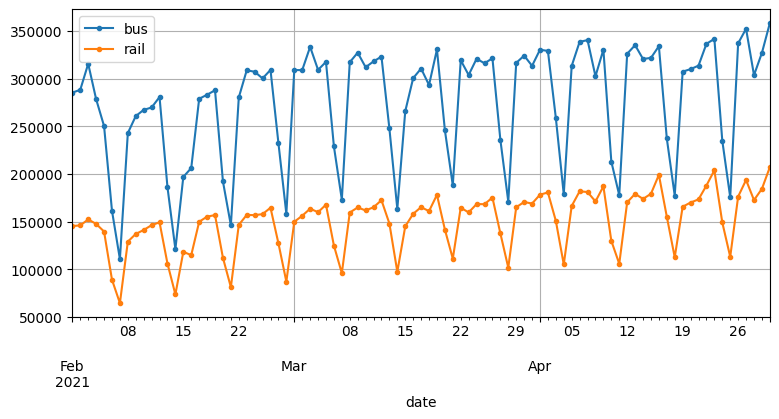

In [4]:
df["2021-02":"2021-04"].plot(grid=True, marker=".", figsize=(9,4))
plt.show()

Quite strong weekly seasonality. 

#### Plot differencing by one week

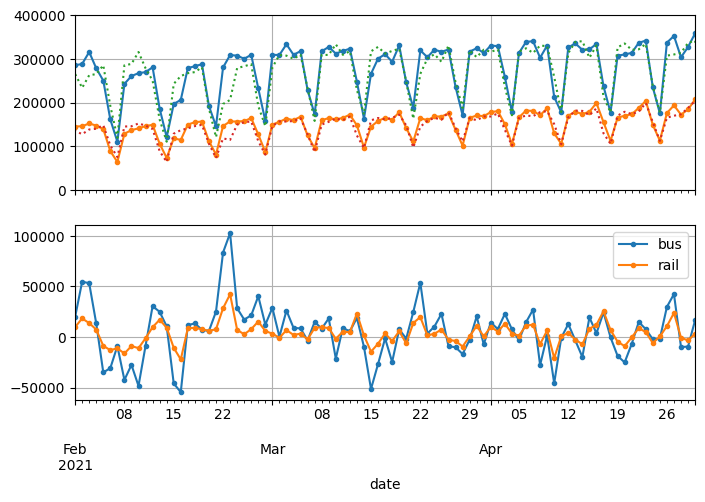

In [5]:
diff_7 = df[["bus", "rail"]].diff(7)["2021-02":"2021-04"]

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=ax[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=ax[0], grid=True, legend=False, linestyle=":")  # lagged time series
diff_7.plot(ax=ax[1], grid=True, marker=".")  # 7-day difference time series
ax[0].set_ylim([0, 400000])  
plt.show()

### Use ARMA (Autoregressive Moving Average) model as a baseline 

Predict ridership for next day

In [6]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series, order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast() 
print("Ridership prediction for next day: ", y_pred)

Ridership prediction for next day:  2019-06-01    427758.626292
Freq: D, dtype: float64


Compare to actual

In [7]:
actual = df["rail"].loc["2019-06-01"]
print("Actual Ridership: ", actual)
arima_error = abs(actual - y_pred.iloc[0])
print(f"Single day ARIMA Prediction Error: {arima_error:.0f}")

Actual Ridership:  379044
Single day ARIMA Prediction Error: 48715


Naive forecast by taking the previous week's value

In [8]:
naive_pred = df["rail"].loc["2019-05-25"]
naive_error = abs(actual - naive_pred)
print(f"Naive Prediction Error: {naive_error:.0f}")

Naive Prediction Error: 47888


Measure Average Forecast Error over a period

In [9]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today], order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # retrain every day
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean() 

print(f"MAE over 3 months: {mae:.0f}")

C:\Users\Jari\AppData\Local\Temp\ipykernel_40556\2089201442.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\Jari\AppData\Local\Temp\ipykernel_40556\2089201442.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\Jari\AppData\Local\Temp\ipykernel_40556\2089201442.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\Jari

MAE over 3 months: 32041


C:\Users\Jari\AppData\Local\Temp\ipykernel_40556\2089201442.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\Jari\AppData\Local\Temp\ipykernel_40556\2089201442.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\Jari\AppData\Local\Temp\ipykernel_40556\2089201442.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\Jari

Baseline measures for comparing RNNs against:

In [10]:
print(f"Single day ARIMA Prediction Error: {arima_error:.0f}")
print(f"Naive Prediction Error: {naive_error:.0f}")
print(f"MAE over 3 months: {mae:.0f}")

Single day ARIMA Prediction Error: 48715
Naive Prediction Error: 47888
MAE over 3 months: 32041


### Prepare data from Machine Learning Models

Split into training, validation, and test datasets

In [11]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_val = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [12]:
seq_len = 56
tf.random.set_seed(42)
ds_train = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets = rail_train[seq_len:],
    sequence_length = seq_len,
    batch_size = 32,
    shuffle = True,
    seed = 42)

ds_val = tf.keras.utils.timeseries_dataset_from_array(
    rail_val.to_numpy(),
    targets = rail_val[seq_len:],
    sequence_length = seq_len,
    batch_size = 32)

Utility function to fit and evaluate a model

In [13]:
def train_and_eval(model, train_set, val_set, learning_rate, epochs=500):
    """
       Train and evaluate a model for the timeseries date
    """
    cb_early_stopping = keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, 
                                                  restore_best_weights=True)
    optim = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=keras.losses.Huber(), optimizer=optim, metrics=["mae"])
    # Train
    history=model.fit(ds_train, validation_data=ds_val, epochs=epochs, 
                      callbacks=[cb_early_stopping])
    
    # Evaluate
    val_loss, val_mae = model.evaluate(ds_val)

    return val_mae * 1e6

### Forecast with a Linear Model

In [14]:
tf.random.set_seed(42)
model_lin = keras.Sequential([
    layers.Dense(1, input_shape=[seq_len])
])

mae_lin = train_and_eval(model_lin, ds_train, ds_val, learning_rate=0.02)



Epoch 1/500


d:\MyGithub\ML_TensorFlow_Keras_Experiments\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3362 - mae: 0.7065 - val_loss: 0.0126 - val_mae: 0.1241
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 - mae: 0.1576 - val_loss: 0.0075 - val_mae: 0.0935
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087 - mae: 0.0967 - val_loss: 0.0056 - val_mae: 0.0756
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - mae: 0.0817 - val_loss: 0.0050 - val_mae: 0.0704
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - mae: 0.0801 - val_loss: 0.0051 - val_mae: 0.0713
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - mae: 0.0818 - val_loss: 0.0048 - val_mae: 0.0692
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - mae: 0.0776 - val_loss: 0.0047 - val_mae: 0.0689
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - mae: 0.0729 - val_loss: 0.0044 - val_mae: 0.0649
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - mae: 0.0

In [15]:
print(f"Linear model Validation MAE: {mae_lin:.0f}")

Linear model Validation MAE: 37421


### Forecast with a Simple RNN

In [22]:
# Dummy RNN model to check how many parameters a SimpleRNN layer has
model_calc_RNN_params = keras.Sequential([
    layers.SimpleRNN(4, input_shape=[None, 1]),
    layers.Dense(1)  # No activation function
])

d:\MyGithub\ML_TensorFlow_Keras_Experiments\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model_calc_RNN_params.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)        │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29 (116.00 B)

 Trainable params: 29 (116.00 B)

 Non-trainable params: 0 (0.00 B)

Define simple one layer RNN

In [19]:
model_simple_RNN = keras.Sequential([
    layers.SimpleRNN(32, input_shape=[None, 1]),
    layers.Dense(1)  # No activation function
])

In [21]:
model_simple_RNN.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,244 (8.77 KB)

 Trainable params: 1,121 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,123 (4.39 KB)

In [24]:
mae_simple_RNN = train_and_eval(model_simple_RNN, ds_train, ds_val, learning_rate=0.05)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0030 - mae: 0.0448 - val_loss: 0.0021 - val_mae: 0.0373
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - mae: 0.0428 - val_loss: 0.0019 - val_mae: 0.0326
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - mae: 0.0403 - val_loss: 0.0023 - val_mae: 0.0429
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - mae: 0.0460 - val_loss: 0.0020 - val_mae: 0.0374
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - mae: 0.0437 - val_loss: 0.0017 - val_mae: 0.0307
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - mae: 0.0419 - val_loss: 0.0018 - val_mae: 0.0326
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - mae: 0.0460 - val_loss: 0.0019 - val_mae: 0.0357
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - mae: 0.0481 - val_loss: 0.0019 - val_mae: 0.0334
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.00

In [25]:
print(f"Simple RNN model Validation MAE: {mae_simple_RNN:.0f}")

Simple RNN model Validation MAE: 29555


### Forecasting with a Deep RNN

In [26]:
tf.random.set_seed(42) 
model_deep_RNN = keras.Sequential([
    layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    layers.SimpleRNN(32, return_sequences=True),
    layers.SimpleRNN(32),
    layers.Dense(1)
])

In [27]:
model_deep_RNN.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, None, 32)       │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,281 (20.63 KB)

 Trainable params: 5,281 (20.63 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
mae_deep_RNN = train_and_eval(model_deep_RNN, ds_train, ds_val, learning_rate=0.01)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0390 - mae: 0.2161 - val_loss: 0.0305 - val_mae: 0.2267
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0173 - mae: 0.1523 - val_loss: 0.0055 - val_mae: 0.0905
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0057 - mae: 0.0804 - val_loss: 0.0027 - val_mae: 0.0554
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0045 - mae: 0.0675 - val_loss: 0.0026 - val_mae: 0.0517
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0047 - mae: 0.0697 - val_loss: 0.0022 - val_mae: 0.0455
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0039 - mae: 0.0574 - val_loss: 0.0025 - val_mae: 0.0483
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0037 - mae: 0.0603 - val_loss: 0.0039 - val_mae: 0.0688
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0041 - mae: 0.0596 - val_loss: 0.0028 - val_mae: 0.0533
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - lo

In [29]:
print(f"Deep RNN model Validation MAE: {mae_deep_RNN:.0f}")

Deep RNN model Validation MAE: 30628
